In [13]:
import pandas as pd
import json
import os
import ast
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv('raiforukraine-MARIA/mcqs_phi3.5_eval.csv')
df.head()

,id,mcq_json,rubric,question,option_a,option_b,option_c,option_d,correct_option,content_gpt,originality,readability,starts_with_negation,is_question,relevance,ambiguity,gpt_answer,disclosure,difficulty
0,OIC-100-01-A,{'question': 'Which of the following statement...,Positive diagnosis,Which of the following statements best describ...,Primary headaches are always benign and do not...,Any sudden headache should be immediately trea...,"Acute headaches, especially those that are unu...",Chronic headaches are always caused by underly...,c,**Item Parent:** Unusual acute and chronic hea...,0.857143,12.037500,False,True,0.783965,0.648546,c,False,3
1,OIC-212-06-A,{'question': 'A patient presents with microcyt...,Etiologies,A patient presents with microcytic anemia and ...,Vitamin B12 deficiency,Iron deficiency,Hepatitis C infection,Chronic lymphocytic leukemia,b,**Item Parent:** Hemograms in adults and child...,1.000000,13.578158,False,True,0.719330,0.587784,b,False,4
2,OIC-330-01-A,{'question': 'Which of the following is NOT a ...,Management,Which of the following is NOT a contraindicati...,History of peptic ulcer disease,Controlled hypertension,Pregnancy from the 6th month onwards,Active peptic ulcer,b,**Item Parent:** Prescription and monitoring o...,0.666667,15.998571,False,True,0.747631,0.530500,b,False,4
3,OIC-330-12-A,{'question': 'Which of the following statement...,Management,Which of the following statements about antiep...,First-generation AEDs were primarily developed...,All AEDs work by directly increasing GABAergic...,Drug interactions are a concern with AEDs due ...,Monitoring epileptic patients should include c...,b,**Item Parent:** Prescription and monitoring o...,1.000000,11.227273,False,True,0.688265,0.647229,b,False,1
4,OIC-330-16-A,{'question': 'Which of the following is NOT a ...,Management,Which of the following is NOT a characteristic...,It has anti-inflammatory properties.,"It can be administered orally, rectally, or in...",It is effective for mild to moderate pain but ...,"Hepatotoxicity is a potential risk, especially...",a,**Item Parent:** Prescription and monitoring o...,0.600000,15.155714,False,True,0.751946,0.666385,a,True,1


# Question mark

In [15]:
# We want to maximize 'True'
question_count = {
    'True': df['is_question'].sum(),
    'False': len(df) - df['is_question'].sum()
}

question_count

{'True': 4642, 'False': 51}

In [46]:
df[df.is_question == False].question.iloc[14]

'According to the provided data, lung cancer ranks as the ______ leading cause of cancer death in mainland France in 2017.'

# Negation

In [25]:
# We want to minimze 'True'
starts_with_negation_count = {
    'True': df['starts_with_negation'].sum(),
    'False': len(df) - df['starts_with_negation'].sum()
}

starts_with_negation_count

{'True': 0, 'False': 4693}

# Originality

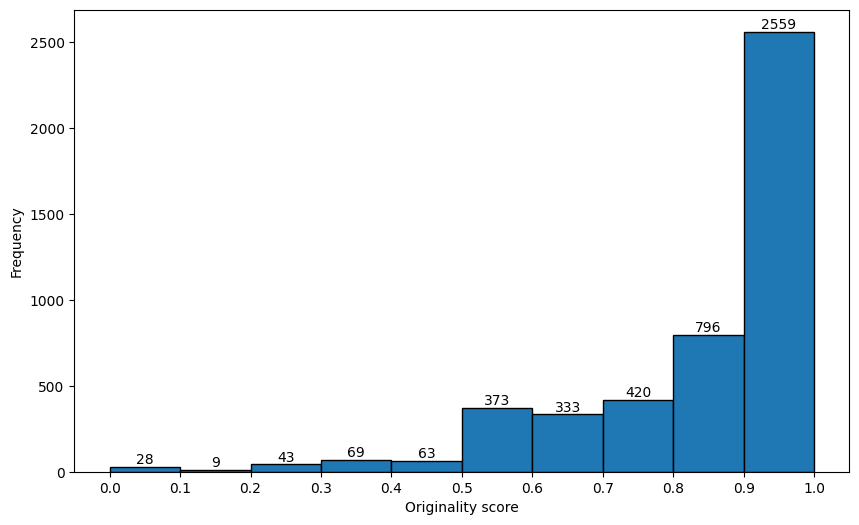

In [26]:
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df['originality'], bins=10, range=(0, 1), edgecolor='black')

plt.xticks([round(x * 0.1, 1) for x in range(11)])

for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
                 ha='center', va='bottom')

plt.xlabel('Originality score')
plt.ylabel('Frequency')
plt.show()

# Readability

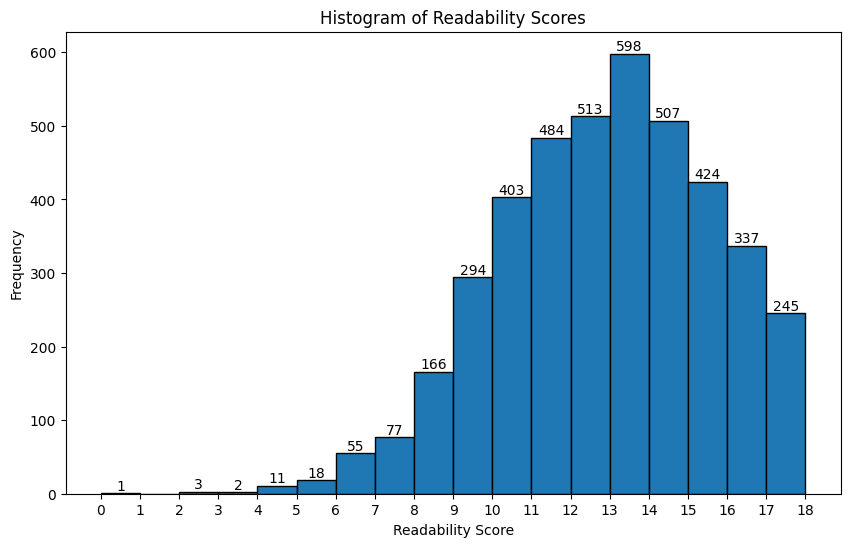

In [27]:
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df['readability'], bins=range(0, 19, 1), edgecolor='black')

# Set x-axis ticks from 0 to 18
plt.xticks(range(0, 19))

# Add frequency labels on top of each bar where frequency > 0
for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
                 ha='center', va='bottom')
plt.xlabel('Readability Score')
plt.ylabel('Frequency')
plt.title('Histogram of Readability Scores')
plt.show()

# Answer Length

In [28]:
option_cols = ['option_a', 'option_b', 'option_c', 'option_d']

# Create new columns with word counts for each option column
for col in option_cols:
    df[f'{col}_word_count'] = df[col].astype(str).apply(lambda x: len(x.split()))

In [29]:
def get_correct_option_rank(row):
    # Get the original word counts for each option
    counts = [
        row['option_a_word_count'],
        row['option_b_word_count'],
        row['option_c_word_count'],
        row['option_d_word_count']
    ]

    # Map correct_option letter to its index (0 for A, 1 for B, etc.)
    letter_to_index = {'A': 0, 'a':0, 'B': 1, 'b':1, 'C': 2, 'c':2, 'D': 3, 'd':3}
    correct_idx = letter_to_index[row['correct_option']]

    # Determine the word count of the correct option
    correct_count = counts[correct_idx]

    # Create an effective counts list:
    # For non-correct options, if their word count equals the correct option's word count,
    # treat them as if they had one extra word.
    effective_counts = []
    for i, count in enumerate(counts):
        if i != correct_idx and count == correct_count:
            effective_counts.append(count + 1)
        else:
            effective_counts.append(count)

    # Sort the option indices by descending effective count.
    ordering = sorted(range(4), key=lambda i: effective_counts[i], reverse=True)

    # Compute the rank as the 1-indexed position of the correct option in the ordering.
    rank = ordering.index(correct_idx) + 1
    return rank

In [30]:
def get_rank_distribution(df):
  rank_distribution = df['correct_option_rank'].value_counts().sort_index()
  rank_distribution = round(rank_distribution / len(df), 2) * 100

  plt.figure(figsize=(8, 6))
  plt.bar(rank_distribution.index, rank_distribution.values, color='skyblue', edgecolor='black')
  plt.xlabel('N (1 = Longest, 4 = Shortest)')
  plt.ylabel('Frequency, %')
  plt.title('How often the correct option is N`th longest')
  plt.xticks([1, 2, 3, 4])
  plt.show()

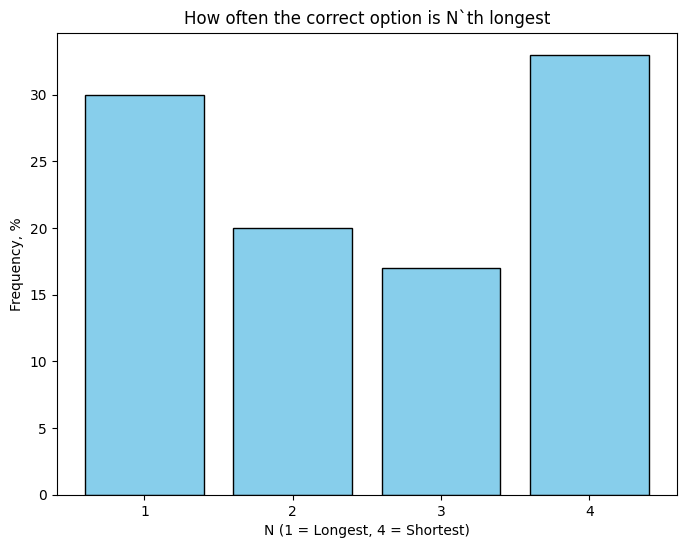

In [31]:
df['correct_option_rank'] = df.apply(get_correct_option_rank, axis=1)
get_rank_distribution(df)

# Disclosure


**Collect metrics on disclosure**

In [33]:
disclosure_count = {
    'True': df['disclosure'].sum(),
    'False': len(df) - df['disclosure'].sum()
}

disclosure_count

{'True': 405, 'False': 4288}

# Relevance to the input material

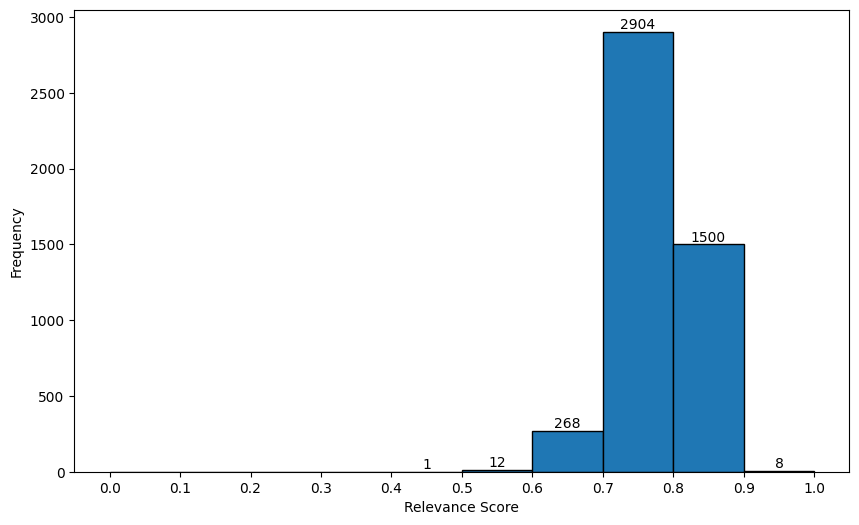

In [34]:
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df['relevance'], bins=10, range=(0, 1), edgecolor='black')

plt.xticks([round(x * 0.1, 1) for x in range(11)])

for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
                 ha='center', va='bottom')

plt.xlabel('Relevance Score')
plt.ylabel('Frequency')
plt.show()

# Ambiguity (difficulty)

## Semantic ambiguity

Text(0.5, 1.0, 'Distribution of Semantic ambiguity')

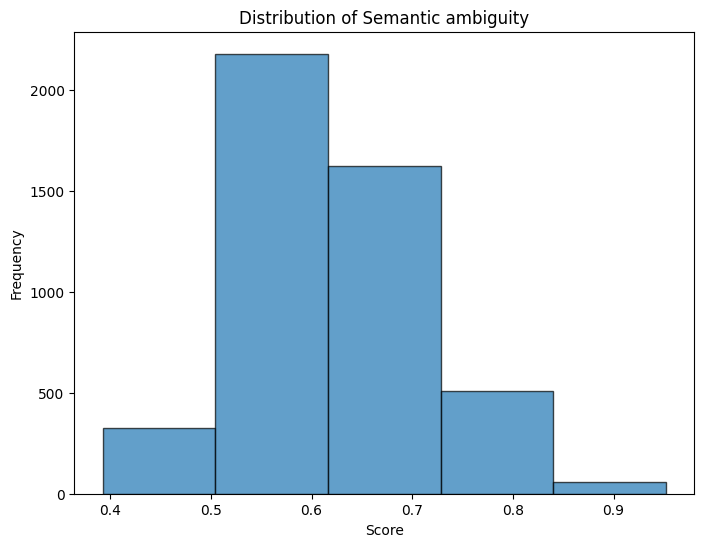

In [40]:
plt.figure(figsize=(8, 6))
plt.hist(df['ambiguity'], bins=5, edgecolor='black', alpha=0.7)

plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Semantic ambiguity")


## syntactic ambiguity

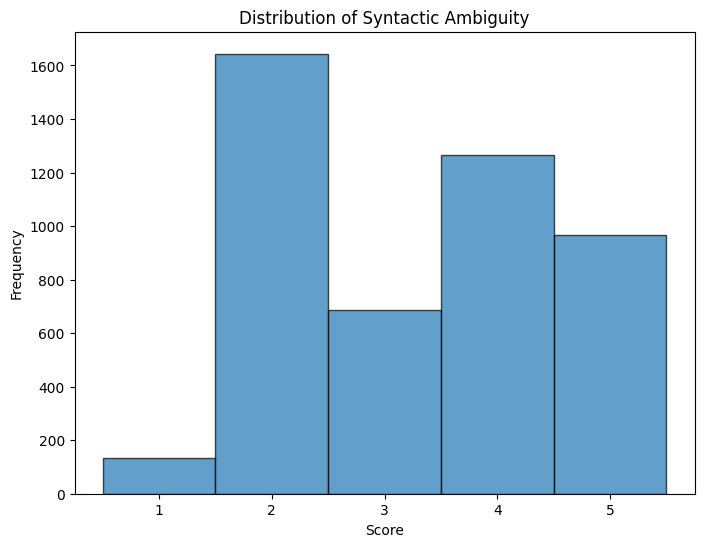

In [43]:
import numpy as np

plt.figure(figsize=(8, 6))
plt.hist(df['difficulty'], bins=np.arange(1, 7)-0.5, edgecolor='black', alpha=0.7)

plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Syntactic Ambiguity")
plt.xticks(range(1, 6))

# Show the plot
plt.show()

# Answerability

### Part 1. compare generated correct option with GPT answer

In [44]:
len(df) - len(df[df.correct_option == df.gpt_answer])

192